# HW2

### Matt Wilde

## Problem 1: The Field of Streams

**Using the data from the SDSS catalog, and Python tools (e.g., matplotlib, numpy), make the analog of Belokurov et al. 2006 "Field of streams" figure (Figure 1 in the paper) encompassing all DR12 data. Specifically:**

* **Write a query (either SQL or for LSD) to select stars satisfying the   color selection criterion (see Section 2 of Belokurov et al. 2006). You're free to either run this query against the CasJobs SDSS database, or the LSD copy of the database.**

I'm going to use our local copy of the sdss database so as to get more practice with LSD

In [56]:
import matplotlib as mpl
mpl.use('GTK')

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
import sqlite3

from lsd import DB
from lsd.bounds import beam, rectangle
import os



plt.rc('font', family='serif', size=15)
#mpl.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})

#use the pretty LaTeX fonts
mpl.rcParams.update({'text.usetex': True})

In [2]:
os.environ['NWORKERS'] = '8'
os.environ['LSD_DB'] = '/astro/apps6/opt/lsddb/'
os.environ['LSD_CACHEDIR'] = '/astro/users/mwilde/tempdir/'
os.environ['LSD_TEMPDIR'] = '/astro/users/mwilde/tempdir/'

In [3]:
print os.environ['NWORKERS']
print os.environ['LSD_DB']
print os.environ['LSD_CACHEDIR']
print os.environ['LSD_TEMPDIR']

8
/astro/apps6/opt/lsddb/
/astro/users/mwilde/tempdir/
/astro/users/mwilde/tempdir/


Connect to our database, and check it out.

In [7]:
db = DB(os.environ['LSD_DB'])

In [8]:
! lsd-admin desc table sdss

Path:          /astro/apps6/opt/lsddb//sdss
Partitioning:  level=6
(t0, dt):      54335.000000, 1.000000 
Rows:          278674212
Columns:       33
Primary key:   sdss_id
Spatial keys:  (ra, dec)
Aliases:       []
Column groups: ['main', 'photometry', 'survey']
-------------------------------
Column group 'main':
              Column       Type
-------------------------------
             sdss_id         u8
                  ra         f8
                 dec         f8
                   l         f8
                   b         f8
                type         i4
               flags         i4
              flags2         i4
      resolve_status         i2
-------------------------------
-------------------------------
Column group 'photometry':
              Column       Type
-------------------------------
                   u         f4
                uErr         f4
                uExt         f4
              uCalib         i2
                   g         f4
                g

Select dereddened g,r and make sure type = 6 to only get stars and not galaxies. 

(r < 22) & (g < 23) 

Belokurov choose to cut their sample at $\alpha = 230$ deg and $\delta = 60$ deg but not doing so here to use all DR12 data which appears larger.

In [10]:
rows = db.query('select sdss_id, ra, dec,  g - gExt as g, r - rExt as r from sdss where (g-r < 0.4) & (type == 6)').fetch()

 [1606 el.]WARNING:lsd.pool2:Error contacting lsd-manager. Cannot coordinate resource usage with others, using 8 cores.
::WARNING:lsd.pool2:Error contacting lsd-manager. Cannot coordinate resource usage with others, using 8 cores.
::::WARNING:lsd.pool2:Error contacting lsd-manager. Cannot coordinate resource usage with others, using 8 cores.
:::WARNING:lsd.pool2:Error contacting lsd-manager. Cannot coordinate resource usage with others, using 8 cores.
:::WARNING:lsd.pool2:Error contacting lsd-manager. Cannot coordinate resource usage with others, using 8 cores.
:::WARNING:lsd.pool2:Error contacting lsd-manager. Cannot coordinate resource usage with others, using 8 cores.
:::WARNING:lsd.pool2:Error contacting lsd-manager. Cannot coordinate resource usage with others, using 8 cores.
::>  194.17 sec


Convert to astropy Table

In [11]:
field = Table(rows.as_ndarray())

* **Write Python code to divide the stars into the three r-band magnitude bins (see the paper and/or the figure caption for magnitude bin specification), and bin them into 0.5 deg x 0.5 deg pixels. You may find numpy.histogram2d helpful.**

Make color bins

In [107]:
#closest
blue = (field['r'] > 20.0) & (field['r'] <= 20.66)

#medium
green = (field['r'] > 20.33) & (field['r'] <= 21.33)

#furthest
red = (field['r'] > 21.33) & (field['r'] <= 22.0)

In [108]:
# check our footprint
print field['ra'].min(), field['ra'].max()
print field['dec'].min(), field['dec'].max()

1.29982855412e-05 359.99999768
-25.0405077253 84.9728649758


bin the sky into 0.5 x 0.5 deg pixels

In [109]:
ra_bin = np.arange(field['ra'].min(), field['ra'].max(), 0.5)
dec_bin = np.arange(field['dec'].min(), field['dec'].max(), 0.5)

make histograms and convert to pixels per 0.5 square degrees `( = / 0.5**2)`

In [110]:
hblue = np.histogram2d(field['ra'][blue],field['dec'][blue],bins=[ra_bin,dec_bin])[0]/(0.5)**2
hgreen = np.histogram2d(field['ra'][green],field['dec'][green],bins=[ra_bin,dec_bin])[0]/(0.5)**2
hred = np.histogram2d(field['ra'][red],field['dec'][red],bins=[ra_bin,dec_bin])[0]/(0.5)**2

In [111]:
hblue

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

* **Use matplotlib.imshow (or any other Python library of your choice) to create an RGB color composite equivalent of Figure 1. from the paper (see the figure caption for details)**


The displayed density ranges are 102–330 (red), 107–304 (green), and 98–267 (blue)

Need to normalize so colors range from 0 to 1


In [112]:
hblue[hblue > 267.] = 267.
hblue[hblue < 98.] = 98.
hblue = (hblue-98.0)/(267.0-98.0)

hgreen[hgreen > 304.] = 304.
hgreen[hgreen < 107.] = 107.
hgreen = (hgreen-107.0)/(304.-107.)

hred[hred > 330.] = 330.
hred[hred < 102.] = 102.
hred = (hred-102.0)/(330.0-102.0)

# make rgb array
rgb = np.array([hred, hgreen, hblue])

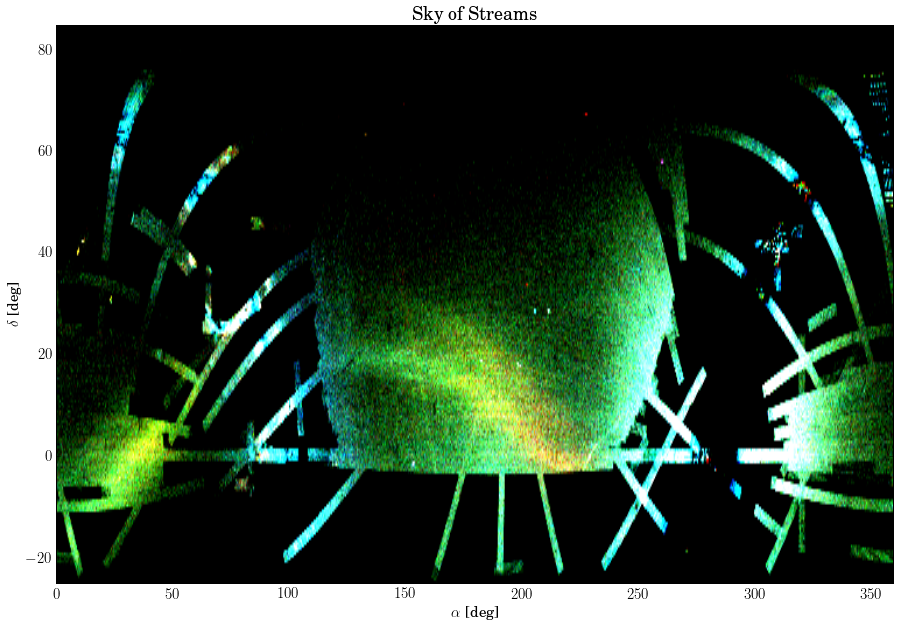

In [116]:
fig, ax = plt.subplots(figsize=(15,10))
img = ax.imshow(rgb.T, origin='lower', \
                extent=(ra_bin[0], ra_bin[-1], dec_bin[0], dec_bin[-1]), aspect='auto')

ax.set_xlabel(r'$\alpha$ [deg]') 
ax.set_ylabel(r'$\delta$ [deg]')
ax.set_title('Sky of Streams')
fig.show()

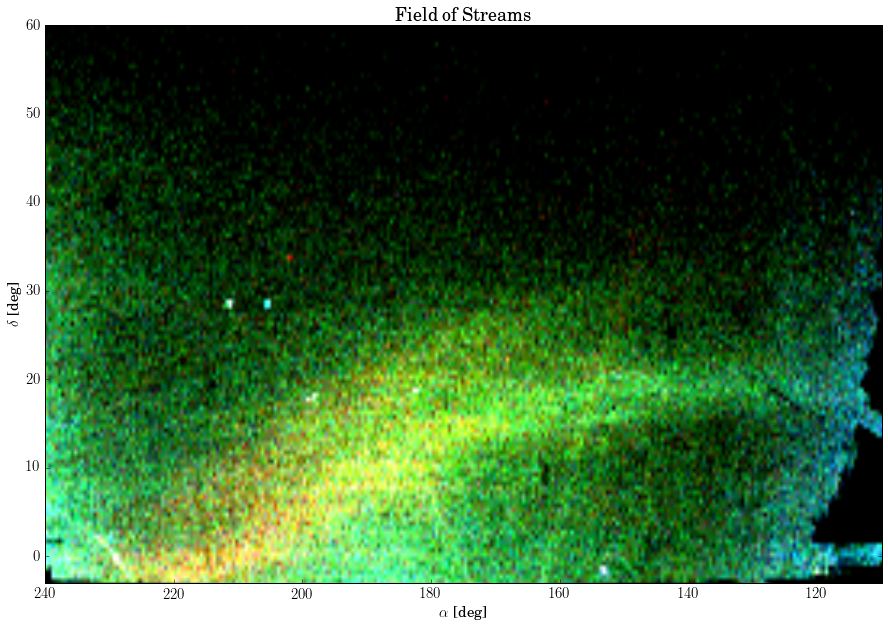

In [120]:
fig, ax = plt.subplots(figsize=(15,10))
img = ax.imshow(rgb.T, origin='lower', \
                extent=(ra_bin[0], ra_bin[-1], dec_bin[0], dec_bin[-1]), aspect='auto')

#img = ax.imshow(rgb.T, origin='lower', aspect='auto')#ax.set_xlim(230,110) 
ax.set_xlim(240,110)
ax.set_ylim(-3,60)
ax.set_xlabel(r'$\alpha$ [deg]') 
ax.set_ylabel(r'$\delta$ [deg]')
ax.set_title('Field of Streams')
fig.show()